# Проект для интернет-магазина "Викишоп"

## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок. Построим модель со значением метрики качества F1 не меньше 0.75.

## Вывод

<div class="alert alert-info">
В данном проекте требовалось помочь интернет-магазину "Викишоп" в запуске его нового сервиса. Необходим инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. Надо было обучить модель разделять на позитивные и негативные комментарии. Данные метрики качества F1 должны быть не меньше 0,75. После загрузки необходимых библиотек для выполения проекта, загрузил файл, изучил и проанализировали данные. При неккоректной загрузке файла появился новый столбец. Удалил его.
    
 - Изучил распределение классов по группам.
 - Провёл лемматизацию данных.
 - Разделил датасет на целевой признак и данные.
 - Разбил выборки на тренировочную и тестовую.
 - Обучил две модели LogisticRegression и LGBMClassifier, значение метрики на тренировочной выборке лучшее на модели LogisticRegression. 
 - Использовал технологию TF-IDF для обработки данных, а так же отфильтровал содержимое при помощи библиотеки nltk.
 - Обучил модели с учетом обработки данных и проверил качество метрики на тестовой выборке.
 - Лучшее значение метрики F1 на тестовой выборке 0.78, у модели LogisticRegression.

 <b>Магазину "ВИКИШОП" можно рекомендовать использование в своей работе мои модели.

## 1. Подготовка

In [1]:
pip install transformers

In [2]:
pip install -U spacy

Note: you may need to restart the kernel to use updated packages.


In [3]:
!python -m spacy download en

     --------------------------------------- 12.8/12.8 MB 24.2 MB/s eta 0:00:00
[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use
the full pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import pandas as pd
import numpy as np 
import re
import nltk
from nltk import corpus
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import transformers

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier


from sklearn.model_selection import cross_val_score
import time
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 

from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet

from nltk.stem import WordNetLemmatizer 

import matplotlib.pyplot as plt


from sklearn.utils import shuffle
from sklearn.metrics import f1_score 
from tqdm import tqdm_notebook as tqdm
from nltk.corpus import stopwords as nltk_stopwords
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
nltk.download('stopwords') 
stop_words = set(nltk_stopwords.words('english')) 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Pletnev\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pletnev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pletnev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
data = pd.read_csv('toxic_comments.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [7]:
data = data.drop(['Unnamed: 0'], axis=1)

In [8]:
print(data.isnull().sum())

print(data[data.duplicated()])

text     0
toxic    0
dtype: int64
Empty DataFrame
Columns: [text, toxic]
Index: []


In [9]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [11]:
corpus = list(data['text'])

In [12]:
lemmatizer = WordNetLemmatizer()
def clear_text(text):
    clean=re.sub(r"[^'a-zA-Z ]", ' ', text) 
    lemmatized_output=" ".join(clean.split())
    return lemmatized_output

In [13]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pletnev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Pletnev\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [16]:
%%time
def lemma_func(text_1):
    lemmatized_output=[]
    for a in nltk.word_tokenize(text_1):
        clean=lemmatizer.lemmatize(a, get_wordnet_pos(a))
        lemmatized_output.append(clean)
    return ' '.join(lemmatized_output) 

lemm=[]
for i in tqdm(range(len(corpus))):
    
    lemm.append(lemma_func(clear_text(corpus[i])))
data['lemmatize']=pd.Series(lemm, index=data.index)

  0%|          | 0/159292 [00:00<?, ?it/s]

Wall time: 2h 23min 39s


In [17]:
data.head()

,text,toxic,lemmatize
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,D'aww He match this background colour I 'm see...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I 'm really not try to edit war It 's ...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I ca n't make any real suggestion on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir be my hero Any chance you remember wha...


<b> Проверил, все хорошо. Теперь разделю датасет на целевые признаки и данные. А также на тренировочные и тестовые выборки.

In [18]:
features = data.drop(['toxic'], axis = 1)
target = data['toxic']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345, shuffle=True,stratify=target)

In [19]:
print(features_train.shape)
print(features_test.shape)

print(target_train.shape)
print(target_test.shape)

(119469, 2)
(39823, 2)
(119469,)
(39823,)


Посмотрю на баланс распределения классов по выборкам.

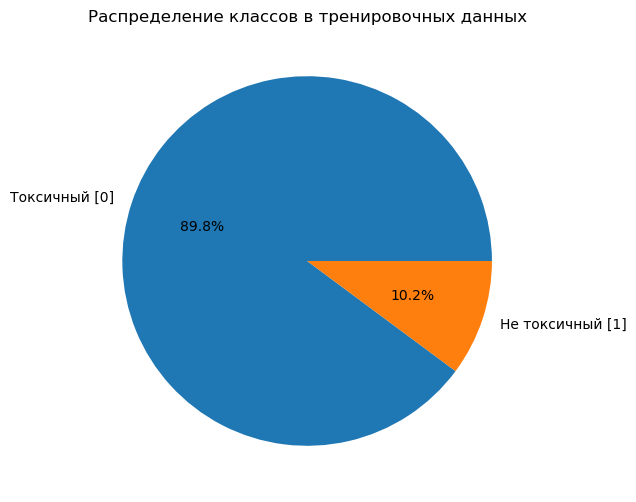

In [20]:
target_train.value_counts(normalize=True).plot(kind='pie',figsize=[6,6], legend=False, autopct='%1.1f%%',labels=['Токсичный [0]','Не токсичный [1]'])
plt.title('Распределение классов в тренировочных данных')
plt.ylabel('')
plt.show()

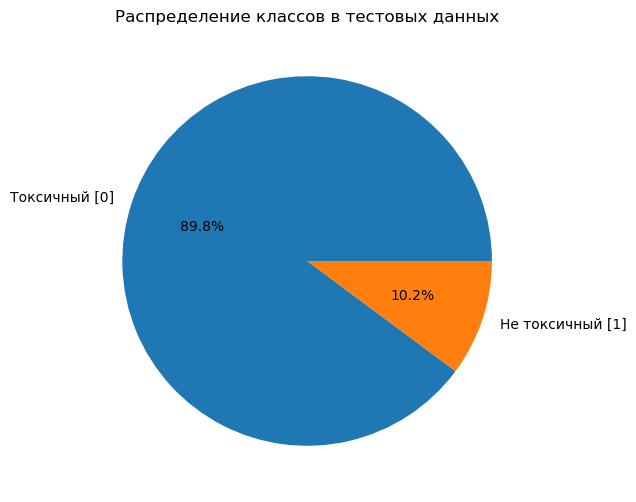

In [21]:
target_test.value_counts(normalize=True).plot(kind='pie',figsize=[6,6], legend=False, autopct='%1.1f%%',labels=['Токсичный [0]','Не токсичный [1]'])
plt.title('Распределение классов в тестовых данных')
plt.ylabel('')
plt.show()

Данные готовы к обучению

## 2. Обучение

In [23]:
features_train.head()

,text,lemmatize
129315,Accusation of vandalism? \n\nWhat was the caus...,Accusation of vandalism What be the cause and ...
8868,Shorter Oxford English Dictionary\nArrived tod...,Shorter Oxford English Dictionary Arrived toda...
75827,"Kim, stop! You are not helping here!!! This is...",Kim stop You be not help here This be fan the ...
137701,My blocking by user Jayron32 \n\nI believe t...,My block by user Jayron I believe that this bl...
28407,Simple quote\nDon't you think this essentially...,Simple quote Do n't you think this essentially...


In [24]:
target_train.head()

129315    0
8868      0
75827     0
137701    0
28407     0
Name: toxic, dtype: int64

In [25]:
%time
log_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1,stop_words=stop_words)),
    ('clf', LogisticRegression(random_state=12345))])

params = {'clf__C': [0.1, 1, 10, 100],
          'clf__class_weight': ['balanced', None]}

log_grid = GridSearchCV(estimator=log_pipe, param_grid=params, cv=3, scoring='f1', n_jobs=-1, refit=False)
log_m  = log_grid.fit(features_train['lemmatize'], target_train)
print(f'Лучшая f1: {log_m.best_score_} при параметрах {log_m.best_params_}')

Wall time: 0 ns
Лучшая f1: 0.7733168985027388 при параметрах {'clf__C': 10, 'clf__class_weight': 'balanced'}


In [26]:
%time
LGBM_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1,stop_words=stop_words)),
    ('clf', LGBMClassifier(random_state=12345))])

params = {'clf__n_estimators': [200],
          'clf__learning_rate': [0.15, 0.25],
          'clf__max_depth': [8, 10, -1]}

LGBM_grid = GridSearchCV(estimator=LGBM_pipe, param_grid=params, cv=3, scoring='f1', n_jobs=-1, refit=False)
LGBM_m  = LGBM_grid.fit(features_train['lemmatize'], target_train)
print(f'Лучшая f1: {LGBM_m.best_score_} при параметрах {LGBM_m.best_params_}')

Wall time: 0 ns
Лучшая f1: 0.7665488368174339 при параметрах {'clf__learning_rate': 0.25, 'clf__max_depth': -1, 'clf__n_estimators': 200}


In [27]:
vectorize = TfidfVectorizer(ngram_range=(1,3),
               min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stop_words)
features_train = vectorize.fit_transform(features_train['lemmatize'])
features_test = vectorize.transform(features_test['lemmatize'])


In [28]:
log_m = LogisticRegression(C=10, class_weight='balanced', random_state=12345)
log_m.fit(features_train, target_train)

LogisticRegression(C=10, class_weight='balanced', random_state=12345)

<b> Проверка показала метрики F1 лучшей модели LogisticRegression.

## 3. Выводы

In [29]:
log_test_pred = log_m.predict(features_test)
f1_log_score = f1_score(target_test,log_test_pred).round(2)

print('F1:', f1_log_score)

F1: 0.78


<b> Лучшее значение метрики F1 на тестовой выборке 0,78 у модели LogisticRegression.

## Выводы

<div class="alert alert-info">
<font size="2"><b> В данном проекте требовалось помочь интернет-магазину "Викишоп" в запуске его нового сервиса. Необходим инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. Надо было обучить модель разделять на позитивные и негативные комментарии. Данные метрики качества F1 должны быть не меньше 0,75. После загрузки необходимых библиотек для выполения проекта, загрузил файл, изучил и проанализировали данные. При неккоректной загрузке файла появился новый столбец. Удалил его.
      Изучил распределение классов по группам
      Провёл лемматизацию данных
      Разделил датасет на целевой признак и данные
      Разбил выборки на тренировочную и тестовую
      Обучил две модели LogisticRegression и LGBMClassifier, значение метрики на тренировочной выборке лучшее на модели LogisticRegression. 
      Использовал технологию TF-IDF для обработки данных, а так же отфильтровал содержимое при помощи библиотеки nltk.
      Обучил модели с учетом обработки данных и проверил качество метрики на тестовой выборке.
      Лучшее значение метрики F1 на тестовой выборке 0.78, у модели LogisticRegression.
      Магазину "ВИКИШОП" можно рекомендовать использование в своей работе мои модели.
       </b></font>